In [1]:
# 1
import torch
from torch import nn,optim
from torch.autograd.variable import Variable
from torchvision import transforms,datasets
from utils import Logger
from IPython import display
import numpy as np
import matplotlib.pyplot as plt

# save net

In [13]:
torch.save(generator,'2_generator_minmax.pkl')

In [14]:
torch.save(generator.state_dict(),'2_generator_params_minmax.pkl')

In [15]:
torch.save(discriminator,'2_discriminator_minmax.pkl')

In [16]:
torch.save(discriminator.state_dict(),'2_discriminator_params_minmax.pkl')

# load net

In [2]:
# 2 
def temper_data(flag="train"):
    if flag == "train":
        return torch.load('../dataloader_temp_train2_new.pt')
        # return torch.load('../dataloader_temp_train2.pt')
    elif flag == 'test':
        return torch.load('../dataloader_temp_test2_new.pt')
        # return torch.load('../dataloader_temp_test2.pt')
    else:
        raise NameError('No such data loader')

train_dataloader = temper_data()
num_batches_train = len(train_dataloader)
test_dataloader = temper_data('test')
num_batches_test = len(test_dataloader)

In [2]:
# 2 
def temper_data(flag="train"):
    if flag == "train":
        return torch.load('../dataloader_temp_train2_new_minmax.pt')
        # return torch.load('../dataloader_temp_train2.pt')
    elif flag == 'test':
        return torch.load('../dataloader_temp_test2_new_minmax.pt')
        # return torch.load('../dataloader_temp_test2.pt')
    else:
        raise NameError('No such data loader')

train_dataloader = temper_data()
num_batches_train = len(train_dataloader)
test_dataloader = temper_data('test')
num_batches_test = len(test_dataloader)

In [3]:
# 3
def images_to_vectors(images):
    return images.view(images.size(0), 133)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 19, 7)

In [4]:
# 4
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [5]:
# 5
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 19*7
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [6]:
# 6
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 19*7
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
#             nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [7]:
# 7 
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [8]:
# 8 
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 400

In [9]:
# 9
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [10]:
# 10
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [11]:
# 11
num_test_samples = 16
test_noise = noise(num_test_samples)

In [12]:
# 12
torch.cuda.is_available()

True

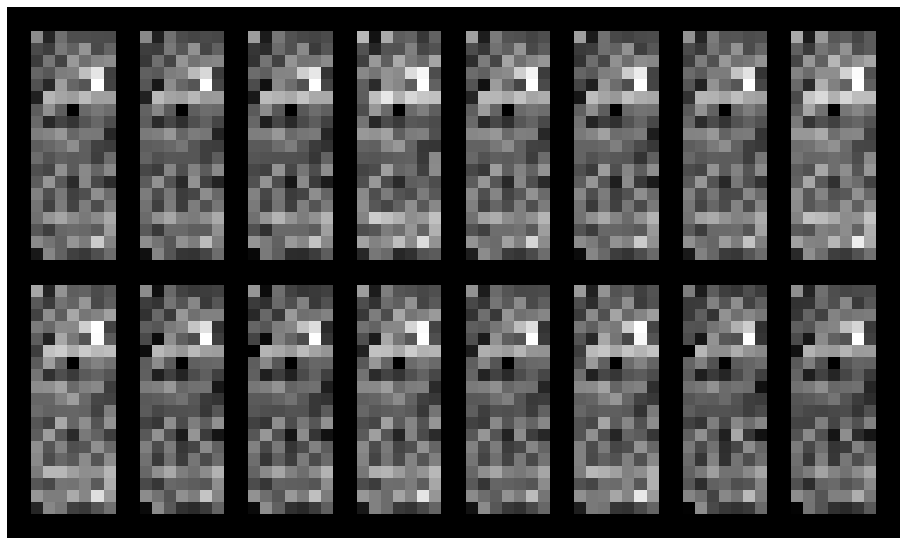

Epoch: [399/400], Batch Num: [50/54]
Discriminator Loss: 1.2904, Generator Loss: 1.1305
D(x): 0.4572, D(G(z)): 0.3910


In [12]:
# 13
logger = Logger(model_name='VGAN', data_name='SS_MINMAX')

for epoch in range(num_epochs):
    for n_batch, (real_batch) in enumerate(train_dataloader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches_train)

        # Display Progress
        if (n_batch) % 10 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches_train);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches_train,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)

In [14]:
mean_list = []
std_list = []
for item in real_data:
#     print(torch.mean(item),torch.std(item))
    mean_list.append(torch.mean(item).cpu().numpy())
    std_list.append(torch.std(item).cpu().numpy())

In [16]:
len(tensor_array)

NameError: name 'tensor_array' is not defined

In [15]:
mean_list = []
std_list = []
for item in tensor_array:
    mean_list.append(np.mean(item))
    std_list.append(np.std(item))

NameError: name 'tensor_array' is not defined

In [44]:
# 14
g2 = generator(noise(29898))
mean_g2 = torch.mean(g2,axis=1)
mean_g2 = mean_g2.cpu().detach().numpy()
std_g2 = torch.std(g2,axis=1)
std_g2 = std_g2.cpu().detach().numpy()
print(mean_g2.shape)
print(std_g2.shape)

(29898,)
(29898,)


/home/esmidth/.pyenv/versions/anaconda3-2020.02/envs/ccs_ta/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/esmidth/.pyenv/versions/anaconda3-2020.02/envs/ccs_ta/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


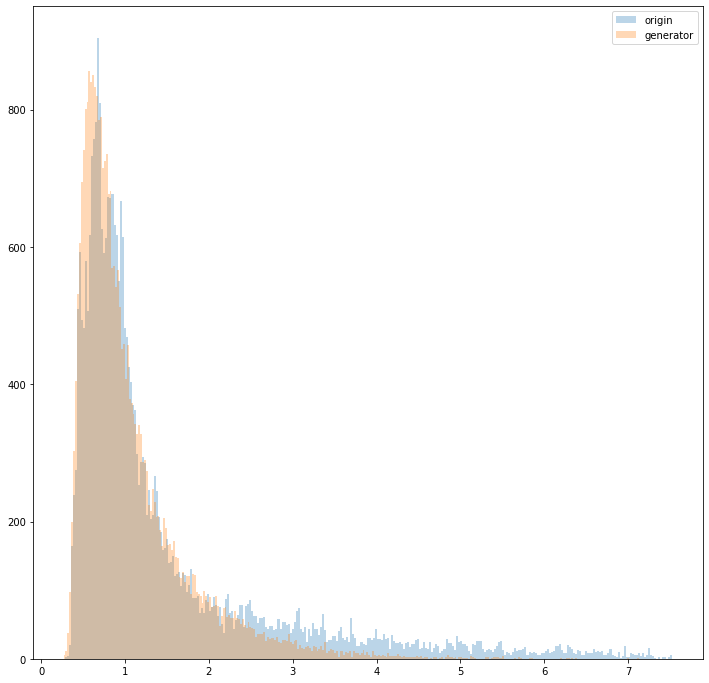

In [52]:
# 15
plt.hist(std_list,bins=300,label='origin',alpha=0.3)
plt.hist(std_g2,bins=300,label='generator',alpha=0.3)
plt.legend()
plt.savefig('1_generated_std_300.png',dpi=300,bbox_inches='tight',pad_inches=0)

/home/esmidth/.pyenv/versions/anaconda3-2020.02/envs/ccs_ta/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/esmidth/.pyenv/versions/anaconda3-2020.02/envs/ccs_ta/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


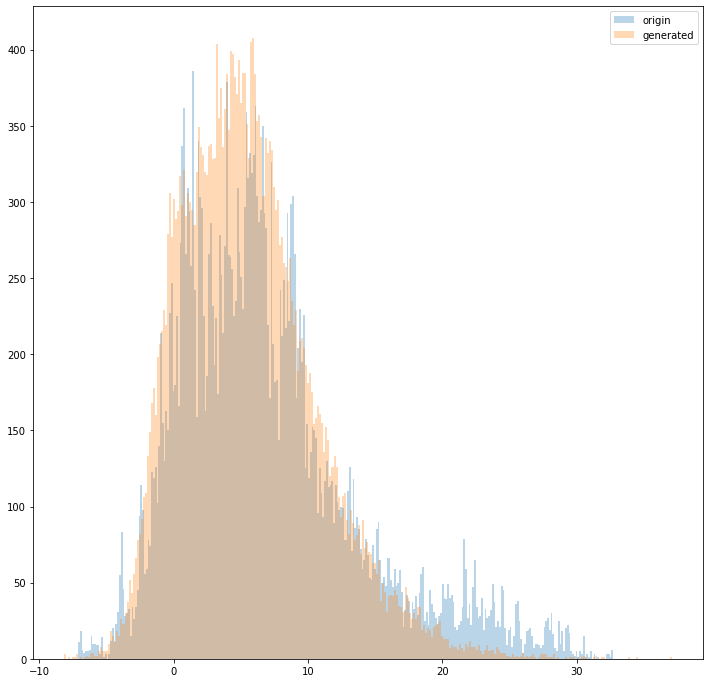

In [53]:
# 16
plt.rcParams['figure.figsize']=(12,12)
plt.hist(mean_list,bins=300,label='origin',alpha=0.3)
plt.hist(mean_g2,bins=300,label='generated',alpha=0.3)
plt.legend()
# plt.savefig('1_genearte_mean.png',dpi=300,)
plt.savefig('1_generated_mean_300.png',dpi=300,bbox_inches='tight',pad_inches=0)

In [ ]:
g2_np = g2.cpu().detach().numpy()

In [ ]:
mean_g2 = torch

In [63]:
while True:
    g1 = generator(noise(1))
    loss = g1.cpu().detach().numpy().reshape(19,7) - tensor_array[10000]
    mre = np.sum(np.abs(loss))
    if mre < 40:
        print(mre)
        break
print(g1)
print(discriminator(g1))

39.19884916324913
tensor([[ 0.9238,  0.7603,  0.8791,  0.8010,  0.7867,  0.9710,  0.9072,  0.5472,
          0.4150,  0.3260,  0.5903,  0.6860,  0.5848,  0.3744,  0.7960,  0.7992,
          0.7641,  1.0533,  0.6075,  0.5420,  0.7108,  0.7288,  0.4624,  0.4082,
          0.3316,  0.5314,  0.6876,  0.7451,  0.3086,  0.3266,  0.2110,  0.0910,
          0.3668,  0.3681,  0.3341,  1.1372,  0.9359,  1.1696,  1.0375,  0.8735,
          1.1510,  0.8164,  0.0498, -0.1312, -0.0227, -0.2448, -0.1414, -0.1387,
         -0.2677,  0.3818,  0.2415,  0.3334,  0.3217,  0.2847,  0.3876,  0.4339,
          2.0175,  1.9727,  1.9019,  2.0963,  2.0069,  2.1373,  1.8645,  1.0143,
          1.0181,  0.8376,  1.0286,  1.0456,  0.9809,  0.9371,  0.4233,  0.3981,
          0.3754,  0.3879,  0.4428,  0.4534,  0.3780,  0.0838,  0.1250, -0.0118,
          0.0528,  0.1787, -0.0044,  0.0602,  0.7830,  0.6750,  0.8194,  0.7190,
          0.5855,  0.6060,  0.5663,  0.8516,  0.8303,  0.5742,  0.4090,  0.5827,
          

In [67]:
mre_loss = []
g1 = generator(noise(100000))
g1_c = g1.cpu().detach().numpy().reshape(100000,19,7)
for i,tensor in enumerate(tensor_array[0:10000]):
    min_mre = 10000
    for j in g1_c:
        loss = j - tensor
        mre = np.sum(np.abs(loss))
        if mre < min_mre:
#             print(i,mre)
            min_mre = mre
    mre_loss.append(min_mre)
    print(i,min_mre)
#     print(i,g1)
#     print(i,discriminator(g1))

0 75.47653457641601
1 80.9043995437622
2 80.93963867950438
3 83.13032820892334
4 82.6637837600708
5 82.94394036102292
6 75.62595223236085
7 108.22988822937013
8 108.66633892059326
9 107.16386173248287
10 105.89395479583739
11 98.74869831085206
12 98.56423311614992
13 100.5158558883667
14 110.13477228546145
15 122.92755399322512
16 131.29131182098388
17 140.19128466033933
18 146.55236115264893
19 146.74050791931154
20 150.86214716339114
21 164.12671579742437
22 98.28239994049072
23 99.65980249786377
24 100.28710086822508
25 85.15227727508545
26 87.35318697357178
27 89.79880821990967
28 90.8334531021118
29 95.21777126312256
30 93.05373172760011
31 93.9343450088501
32 91.76998336029052
33 93.52924674224855
34 93.82972315216065
35 94.9703154067993
36 97.2895107498169
37 97.06237700653077
38 97.73908690643312
39 98.77390637969972
40 96.51261349487305
41 97.08135467529297
42 97.21738731384278
43 97.01272545623779
44 95.71843300628663
45 96.39616034698486
46 95.87976401519775
47 82.7840533828

375 47.91944088745117
376 48.24547282409668
377 47.93131116485595
378 45.93339635086059
379 56.16942166519164
380 56.03354094314575
381 57.52742094039916
382 59.94820397949218
383 58.68692949676513
384 57.57989693260191
385 49.7650199584961
386 50.726875038146964
387 56.28088475418089
388 62.20735541725159
389 64.12770805931092
390 67.29835925102235
391 67.63967799949647
392 68.57481152153017
393 69.85300679779053
394 70.55816634368898
395 70.26502728080749
396 64.16751588153839
397 65.08870986366273
398 54.289973126888285
399 50.41841497707367
400 49.66201191616058
401 49.85485556697844
402 53.41595316219329
403 54.71399537467956
404 54.61069606876373
405 54.49018037223816
406 55.22949381637574
407 54.5331821088791
408 58.413069560050964
409 56.43057303905488
410 54.01397998428344
411 56.74264066314696
412 55.68368446731567
413 56.124162746429434
414 50.99205305480956
415 52.18888659286498
416 51.55001522827148
417 53.163331287384025
418 52.706257740020746
419 54.575142326354964
420 5

745 59.26207726943493
746 59.06695665609837
747 58.46670731621981
748 57.58788646537066
749 53.22564262610675
750 52.790641287624844
751 54.37547302895785
752 47.572594529449944
753 47.195913907349116
754 40.733698096573356
755 55.392000876724715
756 55.06923743277788
757 43.18002260443569
758 44.6517615146339
759 46.14317501747609
760 52.04179289305211
761 41.073016953773795
762 40.51075468022377
763 42.91348339278251
764 42.02118991214782
765 39.62341380674392
766 39.84586043602974
767 45.396850915327676
768 40.538223677948125
769 41.90839695718884
770 41.63014814175665
771 42.49641407209635
772 41.75283948899806
773 41.28088363827765
774 42.18805234605074
775 41.29956612892449
776 45.609753317937255
777 46.17150095422566
778 45.363072215303774
779 46.625790744975205
780 47.08930755995213
781 44.77333364732563
782 41.92061781312526
783 42.09207013900578
784 42.974331207275384
785 41.88128901858627
786 39.03518910840154
787 41.021656395345914
788 40.52550742921233
789 41.4873962972462

1109 47.199743003845214
1110 49.52839919805527
1111 52.37803427505494
1112 54.3423600473404
1113 51.15702081537246
1114 52.21680320119857
1115 46.775662239074705
1116 48.057660171031955
1117 48.869303649425504
1118 47.50572564554214
1119 46.815662110328674
1120 38.043271775126456
1121 44.344514690756796
1122 42.84185674512386
1123 42.84813968217372
1124 42.72574444854259
1125 43.38654936635494
1126 43.27059074771404
1127 42.88128162419795
1128 44.46203360307216
1129 46.14241537928581
1130 43.76843451380729
1131 43.59916155171395
1132 45.21752831530571
1133 43.51425241601467
1134 44.15702709805965
1135 43.356067985892295
1136 44.45968395972252
1137 137.57743754599989
1138 235.5226019268036
1139 235.07434911727904
1140 237.25401735305786
1141 251.50803330230718
1142 251.71195601654054
1143 248.88679071044925
1144 250.1564773101807
1145 250.41869754028326
1146 249.3227076568604
1147 247.3335049438477
1148 244.9696678695679
1149 252.99645478057866
1150 255.1417134552002
1151 251.7940567150

1461 50.79568220114709
1462 51.02157309699059
1463 51.21883206915856
1464 55.95622921764851
1465 54.391851272702226
1466 55.1276240388155
1467 56.33481413280964
1468 56.03238557827474
1469 58.10740642142297
1470 54.56428826689721
1471 56.00973716330529
1472 56.938291541814806
1473 54.722822178840644
1474 55.94251237177849
1475 51.495222142219546
1476 55.88071011829377
1477 43.46712126615644
1478 46.79115045920014
1479 45.02204940441251
1480 45.21209687168151
1481 43.187063568182296
1482 50.5111933875978
1483 51.591401059001676
1484 48.80626730403304
1485 48.29556791391969
1486 35.55086835419387
1487 26.889320491548624
1488 27.23470071752369
1489 26.534031780943273
1490 26.210908295430244
1491 25.162823851585387
1492 26.86356425380707
1493 26.315832118034365
1494 27.563988465309144
1495 28.66620116329193
1496 28.397117324829104
1497 29.81862773227692
1498 29.310831768035897
1499 28.523706698417666
1500 28.96497731781006
1501 29.14734993648529
1502 28.884369711875912
1503 36.639697728097

1814 66.65942114424703
1815 66.91823782515526
1816 65.79577494597436
1817 64.47442510557175
1818 61.712958055019385
1819 54.95632748007775
1820 54.699785718679436
1821 53.31461987829209
1822 52.3818258061409
1823 52.24752024793625
1824 49.47797970199585
1825 50.50407095766067
1826 50.13170389705897
1827 50.429512588202954
1828 48.87521731001138
1829 48.54373676556348
1830 47.15067811399698
1831 46.29028177982569
1832 47.70185355526209
1833 46.83174764195085
1834 44.176068656772365
1835 42.95542027679085
1836 43.20454811391234
1837 43.551311311811205
1838 43.42333014282584
1839 44.22393549796939
1840 42.91907703444362
1841 44.05731932970882
1842 43.342028774410494
1843 41.48304431024194
1844 41.371564336761836
1845 37.156189923971894
1846 35.776020905166874
1847 34.02955907853693
1848 32.54205793094635
1849 32.66382843482494
1850 27.954190070688725
1851 28.735948212683198
1852 27.575431062638764
1853 27.36712007288635
1854 28.68970598654449
1855 26.165706168815497
1856 27.43887088029086

2164 28.955755057334905
2165 29.438117120742803
2166 28.803069439411164
2167 29.195198878765105
2168 30.10988513374329
2169 30.641518755853184
2170 29.52449789333344
2171 28.842494678497317
2172 29.882117155075075
2173 29.639942005157472
2174 29.109247960984707
2175 28.79196178865433
2176 28.42544148349762
2177 28.66000174379349
2178 29.56644003701211
2179 28.164181119896472
2180 28.78254334282876
2181 28.584262204147876
2182 29.208537209726874
2183 29.006680449463428
2184 29.096058404147627
2185 28.36375943925977
2186 28.726236201733357
2187 29.222199655383825
2188 28.677021036125716
2189 28.660027928330003
2190 26.708392304398124
2191 28.659602856852118
2192 29.25805313372612
2193 28.779897923447194
2194 29.266828283287587
2195 28.948492648102345
2196 27.440964517332617
2197 28.131895509459078
2198 29.123954689957205
2199 28.675410455919803
2200 27.297155228830874
2201 26.672995111443104
2202 26.656326297260826
2203 28.906833559490742
2204 28.365240826345982
2205 27.846982325293126
2

2512 27.227566210627558
2513 26.943154462277892
2514 26.919716899693015
2515 28.02273294633627
2516 27.380127499341967
2517 27.41947640642524
2518 26.63485448476672
2519 27.220110712081194
2520 26.221729602843524
2521 26.86842654052377
2522 27.637251696795225
2523 27.617294984847305
2524 28.18095153412223
2525 26.992953257471324
2526 27.285753061503172
2527 27.19963247266412
2528 26.826377152711153
2529 26.760831944793466
2530 27.949331362873316
2531 27.685263568073516
2532 26.007840604513884
2533 26.362378992825747
2534 28.781401254087694
2535 28.16537709727884
2536 28.968593162149197
2537 29.476207556277515
2538 29.340189352452754
2539 30.152513007104396
2540 29.85942810708284
2541 28.68401783705503
2542 27.79857597097755
2543 28.690287964433438
2544 28.939960464805367
2545 26.81018279247731
2546 26.884198962144552
2547 27.109943755030635
2548 28.09697445186973
2549 27.38980817639083
2550 30.522788501292467
2551 28.466636937908834
2552 27.44949888443202
2553 28.322528859585525
2554 2

2860 27.609947550296788
2861 27.711821950435642
2862 27.93454996156693
2863 28.47932128095627
2864 30.032753778934485
2865 29.82829007196427
2866 29.95446453428269
2867 29.55248266839982
2868 30.06038254594803
2869 30.772208595752723
2870 30.981322579860695
2871 30.11800331830979
2872 29.91280359220505
2873 31.36175234603882
2874 31.25572950744629
2875 31.719671593666078
2876 29.701103674411772
2877 28.458243105411533
2878 27.31513575220108
2879 28.47361670160294
2880 29.373778573513036
2881 28.79054630994797
2882 46.09421914958954
2883 44.53505926418305
2884 39.75468312740327
2885 40.294034708976746
2886 39.44112460041046
2887 38.75477959728242
2888 39.543946887016304
2889 40.3877884759903
2890 39.689066355705265
2891 39.7478772687912
2892 37.56343885326386
2893 34.93955307769775
2894 36.94160483360291
2895 36.01403310775758
2896 36.12793877410889
2897 36.77015789222718
2898 37.50701747512818
2899 37.900011629104625
2900 35.82995874404908
2901 32.42813742256165
2902 32.60623475456239


3210 31.620695367813113
3211 32.392763139724735
3212 31.25326469993591
3213 30.990889245986942
3214 31.21932407188416
3215 31.726676374435428
3216 30.409060129165656
3217 30.31188463115692
3218 29.782120215415958
3219 31.328631315231323
3220 31.13321510982513
3221 32.033414575576785
3222 33.64305273246765
3223 33.66773478031159
3224 33.405927924156195
3225 35.22585252952575
3226 33.85547783374787
3227 32.96494141483308
3228 34.29735530090332
3229 31.382921133041386
3230 28.9189986782074
3231 29.722952764511106
3232 28.256120965957642
3233 28.503373439788824
3234 28.203882198333744
3235 28.459177904129028
3236 27.547187845230106
3237 27.1670606880188
3238 27.68752948951721
3239 27.369848680496215
3240 26.62578897857666
3241 27.244846344947817
3242 28.364197555541995
3243 28.55617796802521
3244 28.24509371089936
3245 29.16958068084716
3246 29.17974921607971
3247 28.55541986083984
3248 28.754206521034245
3249 27.836480047225955
3250 27.21958061790466
3251 26.770240536689762
3252 26.383584

3560 94.09616157150268
3561 98.89175234222411
3562 101.4191675453186
3563 101.95166213417052
3564 101.5932453651428
3565 102.5460281047821
3566 70.71813998603821
3567 69.90342150878905
3568 67.87990701293944
3569 68.45530429840089
3570 66.4965209655762
3571 63.832160766601575
3572 64.36106561279297
3573 80.65173077011107
3574 58.580795623779295
3575 57.41411666107177
3576 58.50828488159179
3577 55.866171173095694
3578 57.290093643188484
3579 57.24694620513916
3580 57.42858604812622
3581 59.40032310485839
3582 58.80353632354738
3583 57.41500754165649
3584 59.242180301666245
3585 59.22939809799193
3586 54.49820629501342
3587 55.15058192062377
3588 53.850424251556404
3589 54.834456172943106
3590 54.25289011001587
3591 52.88130865859986
3592 52.58959283828736
3593 51.25603576278688
3594 51.94840881729126
3595 53.33213489913941
3596 53.93969108963013
3597 55.23384364700317
3598 54.66610612869262
3599 54.288488391876214
3600 54.56002630996705
3601 52.80479446411133
3602 54.22971619415283
360

3913 57.43869282913207
3914 62.11006130599974
3915 59.777915950775125
3916 58.968165935516346
3917 60.464798709869356
3918 60.318821445465076
3919 59.998947917938224
3920 59.18994408798218
3921 58.540164180755625
3922 59.49864366149903
3923 59.5076964149475
3924 61.93910606765747
3925 60.12941630172729
3926 60.586179950714104
3927 60.81170758438111
3928 58.906099063873285
3929 61.12347316360473
3930 63.600029880523685
3931 61.744431251525874
3932 61.77320116424559
3933 61.47030191802979
3934 60.37805776214599
3935 61.13109064483643
3936 60.59049691772461
3937 60.60972551727295
3938 63.30847982025146
3939 64.5153127746582
3940 64.45423136901854
3941 65.70304567718506
3942 66.29896050262451
3943 66.58488348388671
3944 66.91975455474852
3945 66.65515625762939
3946 65.82134825134277
3947 65.69890064239502
3948 64.55472966766357
3949 64.08743830108642
3950 64.33033190917969
3951 63.172238983154294
3952 64.17666558074951
3953 64.74303050994874
3954 63.96710752105714
3955 64.37390238189697
39

4269 53.91476704788209
4270 55.440842567443845
4271 55.59237912750244
4272 56.131608901977536
4273 57.21077158737182
4274 56.415238204956054
4275 55.201073223114015
4276 57.70972045135498
4277 56.13814251708983
4278 52.38437616729736
4279 53.26410336303711
4280 53.052621360778815
4281 54.051425144195555
4282 54.29624936294556
4283 44.015093589782715
4284 44.89330550575255
4285 44.35553480720518
4286 39.32781048202514
4287 52.35689770126343
4288 52.91986173820496
4289 50.92550551223755
4290 51.122026897430416
4291 43.41550513267518
4292 37.60531696510314
4293 37.49845021247863
4294 31.394511959075928
4295 30.304074783325195
4296 31.023035110473632
4297 31.09988958740234
4298 30.589950294494628
4299 30.941888427734376
4300 31.70598955154419
4301 32.753859558105475
4302 33.447058557510374
4303 33.10791216850281
4304 33.68013683509827
4305 73.0729717516899
4306 73.6323602118492
4307 72.90653614807131
4308 69.74819458913804
4309 69.8867283654213
4310 70.89071174287797
4311 49.75719059991837

4621 32.89751538276671
4622 35.70985756492614
4623 36.323503450393666
4624 36.98374220657348
4625 36.662879024505614
4626 37.60451945114135
4627 38.7685927581787
4628 41.113731163024894
4629 69.3054353313446
4630 70.41680839538574
4631 71.0192089073658
4632 72.2924779961109
4633 71.81299446511268
4634 72.62783595871926
4635 73.97092882370949
4636 73.33667160773277
4637 74.2399569773674
4638 73.39369689702988
4639 72.93535972642898
4640 71.41767053079606
4641 70.9639677014351
4642 70.1226971859932
4643 66.94052042436599
4644 67.10024679708481
4645 64.51585379838943
4646 62.905575600147245
4647 62.8117043414116
4648 63.18940499877928
4649 62.28459182739256
4650 61.51173435211179
4651 61.9760485153198
4652 61.379251747131335
4653 61.90482604980468
4654 63.677400810241686
4655 62.83779319763184
4656 64.30288235473633
4657 63.732739883422866
4658 65.64277439880374
4659 66.67300741577148
4660 66.1114030303955
4661 65.52154754638673
4662 66.15755032348633
4663 65.98784798049927
4664 65.225372

4976 51.9584567527771
4977 50.54523567581178
4978 51.964752765655525
4979 52.2009286994934
4980 49.25220992660522
4981 47.89652894210814
4982 50.38929569625854
4983 50.795751262664794
4984 52.887031223297114
4985 57.445663696289074
4986 59.03828604888915
4987 60.481215198516836
4988 60.08477238464354
4989 59.52659566879271
4990 59.7293371925354
4991 63.658755252838134
4992 67.31373117446901
4993 72.36658488464356
4994 72.16067657470703
4995 74.14273434448242
4996 72.85633920288086
4997 71.94658186340332
4998 68.89700551605225
4999 69.0746360473633
5000 67.67951184844972
5001 73.45785552215577
5002 63.42895471191405
5003 61.40874514007569
5004 60.78308482360839
5005 62.708205291748044
5006 59.56763465881349
5007 59.09959343719484
5008 60.887721336364756
5009 60.25709924316408
5010 63.54500399780275
5011 70.8263045425415
5012 73.7973198776245
5013 69.19653162384034
5014 67.19878845977783
5015 66.17016143035889
5016 63.30999162292481
5017 63.72250819778442
5018 66.29045946884158
5019 66.3

5330 78.13551582336429
5331 77.34334707641602
5332 76.31781630706789
5333 73.18925147247316
5334 72.32299448394778
5335 83.96122039031982
5336 75.87509214782715
5337 73.50900708770752
5338 73.79102715301512
5339 72.98364530944824
5340 72.71139347839355
5341 73.31022805023193
5342 73.74090003967285
5343 72.79482134246827
5344 73.10506496429443
5345 73.05251987457277
5346 72.21374198150635
5347 71.3842141494751
5348 70.10797949981688
5349 71.4909642868042
5350 71.17095615386964
5351 70.73842398834228
5352 77.19251131439208
5353 76.10340167999266
5354 75.70280326080322
5355 74.25575082397461
5356 72.63046295166015
5357 73.89013768005371
5358 73.8440664291382
5359 65.39985485839844
5360 66.17888710021973
5361 64.97103628540039
5362 63.37644351196289
5363 62.64712021636964
5364 61.510508171081554
5365 65.00350408172606
5366 65.52467753601073
5367 66.83229093170166
5368 68.82789067840575
5369 70.61289969635008
5370 69.18470775604246
5371 69.15027873992919
5372 69.66684351348877
5373 68.97849

5685 54.24464853668213
5686 54.87157716369629
5687 54.10253811645508
5688 58.06051767730712
5689 57.96601472854614
5690 56.90474918746948
5691 57.26636079025269
5692 56.66098376846314
5693 57.72369507217409
5694 63.486996738433845
5695 63.56553511428834
5696 63.19947743225099
5697 63.48303811645508
5698 62.63710241699218
5699 61.21899518966674
5700 69.26214610290526
5701 67.44375133895875
5702 68.82761853027344
5703 69.08866419982911
5704 70.48678749084472
5705 70.47487731170654
5706 73.54093489074705
5707 72.86235134887694
5708 62.72930667877199
5709 69.75392607879638
5710 71.81335675811769
5711 80.98370537567138
5712 77.92699701690674
5713 80.80320726776122
5714 83.741663230896
5715 82.17830099487307
5716 79.8263563232422
5717 81.04848399353025
5718 80.56576062774658
5719 77.09229138946533
5720 77.01305594635008
5721 76.3074637069702
5722 77.97400128936768
5723 81.08418849945068
5724 82.88395636749266
5725 82.86679527282715
5726 73.27991928863526
5727 76.62485175323488
5728 78.416023

6043 85.98509291076661
6044 91.12427894592287
6045 93.10388717651367
6046 90.39323419189455
6047 88.23995346069336
6048 85.1288323059082
6049 86.30431402587891
6050 106.04668572235107
6051 107.78410312652588
6052 123.90271347045902
6053 125.43483321380619
6054 128.4502979049683
6055 131.1576194229126
6056 133.69169229888917
6057 139.21721839141847
6058 139.0299045944214
6059 139.05355098724363
6060 138.9958654098511
6061 183.57283705139162
6062 184.56992498779294
6063 185.53059811401369
6064 189.25167938232426
6065 190.11451362609864
6066 182.08505596923828
6067 224.66150107574464
6068 224.5296433944702
6069 223.85413303375248
6070 236.46525514984134
6071 237.50515308380122
6072 237.40550516510012
6073 237.73686949920653
6074 230.7761565322876
6075 230.1769134140015
6076 230.26691298675541
6077 248.75462911224366
6078 250.41227294158938
6079 253.37888997650148
6080 246.43209532928472
6081 244.98578583526614
6082 207.04156280517577
6083 209.57496420288084
6084 194.78071530151368
6085 19

6396 55.62893260192871
6397 55.72276000213621
6398 55.88685974884032
6399 63.42597213363646
6400 64.17260479354857
6401 62.56056167221069
6402 62.54536605453491
6403 61.03210190200804
6404 60.83182930374144
6405 59.2317631225586
6406 53.461850063323965
6407 53.563141998291
6408 51.60079882812499
6409 61.16735227584838
6410 60.4951855430603
6411 61.231908489227294
6412 61.06881377792358
6413 68.56244816970826
6414 64.24652302169801
6415 59.497132637023924
6416 61.45154160308838
6417 60.90545475769042
6418 71.2171435432434
6419 84.63923266220093
6420 84.13765407943725
6421 132.60307808685303
6422 132.36037647247312
6423 129.47151547622678
6424 181.52205488586424
6425 179.92845030975343
6426 166.160340927124
6427 172.7601731262207
6428 175.35455453491213
6429 177.4073581695557
6430 180.42820207214356
6431 180.1984327697754
6432 182.97634272766112
6433 182.70589529418945
6434 181.80514799499514
6435 180.45163536834716
6436 179.68838359832762
6437 182.09921852874757
6438 179.89630720901488


6750 65.402652885437
6751 66.41459990692138
6752 66.35750064849853
6753 71.50565941619874
6754 76.09017908477784
6755 76.96659562683107
6756 76.19019936370852
6757 76.43891931915284
6758 77.70614644622805
6759 77.15011832427979
6760 184.55949784088136
6761 188.66559580230717
6762 144.6121421585083
6763 138.21167635345455
6764 130.8075093307495
6765 128.99606714630127
6766 121.99324852752687
6767 116.00452716827391
6768 158.1821556777954
6769 140.08233965301514
6770 128.40768465423585
6771 127.60810860443115
6772 128.9272819442749
6773 129.52177713775635
6774 132.4509196548462
6775 131.76366782379148
6776 110.12420903778079
6777 109.7186630783081
6778 109.96765942382814
6779 112.06953507232666
6780 111.07450207519531
6781 112.87285482788084
6782 111.97817340469359
6783 93.73202513504029
6784 84.40322453689575
6785 79.38892301177978
6786 79.54540811920165
6787 80.72956813812256
6788 81.10799744415283
6789 82.26559344482422
6790 82.7550348739624
6791 94.47969975280762
6792 95.919445953369

7105 182.60280827426914
7106 229.43158070468905
7107 231.22125284290314
7108 268.6116255340576
7109 267.54698915863037
7110 267.53991931915283
7111 269.431403388977
7112 269.67971440887453
7113 270.49621907043456
7114 281.66315296554563
7115 277.9761529655457
7116 274.32367493820186
7117 291.2959834709168
7118 291.54417950057984
7119 291.7690404548645
7120 289.3320404548645
7121 286.6818914451599
7122 270.35380458068846
7123 270.83704171752925
7124 271.61020233154295
7125 273.850572052002
7126 275.3130274963379
7127 285.3408692321778
7128 289.9015872802735
7129 291.04905288696295
7130 291.91589729309084
7131 293.1917612838745
7132 284.8411643753052
7133 286.24515870666505
7134 287.7614845275879
7135 289.88238669586184
7136 289.7744735641479
7137 290.41323122406004
7138 288.71011209869386
7139 273.6538350753784
7140 274.0160375442505
7141 253.3686528091431
7142 253.47300811004644
7143 255.60963961029057
7144 258.99740834808347
7145 261.36820601654057
7146 264.0408449325562
7147 273.0195

7460 39.64013209152222
7461 41.55022942733765
7462 39.026350387573245
7463 36.79182411575317
7464 38.33353892898559
7465 36.753279865264886
7466 34.76115866470337
7467 35.996224529266364
7468 36.86617390823365
7469 36.611135463714604
7470 35.96177907943726
7471 37.0903956489563
7472 38.828459842681895
7473 38.69476873397828
7474 38.149478679656994
7475 38.86561777114869
7476 37.912816028594975
7477 40.70007284164428
7478 39.009562839508064
7479 39.04626266860963
7480 39.19761959838866
7481 39.83684448242188
7482 40.14557823944092
7483 40.9506140022278
7484 40.38696265411377
7485 40.90295162582398
7486 39.99003266525268
7487 41.27398746109009
7488 39.907055316925046
7489 40.81460218429565
7490 42.06637270355225
7491 39.956741790771474
7492 39.51549291229246
7493 37.845125045776356
7494 38.205112251281754
7495 39.80945233917237
7496 41.56319203948975
7497 42.468600097656264
7498 40.65222684860231
7499 41.91092316818238
7500 41.96475930786133
7501 41.403741653442395
7502 40.12606605911257

7813 61.29283026313781
7814 59.8051189842224
7815 58.780253261566145
7816 78.61735426330567
7817 79.50281785583496
7818 81.30007480621339
7819 79.84831681060791
7820 79.01590045928957
7821 101.42220616149903
7822 101.15127336883546
7823 101.117256439209
7824 101.99673524475098
7825 102.42271659851073
7826 102.7932541770935
7827 128.02690362739565
7828 130.51861842536928
7829 132.08055249214175
7830 132.88820634269717
7831 132.8805094585419
7832 140.24699227333073
7833 142.24255808448794
7834 144.31126758766177
7835 147.27627388954167
7836 150.43131391716008
7837 150.88769437980653
7838 151.46196501350403
7839 152.0678965930939
7840 153.3672223300934
7841 101.15220407485963
7842 105.8252993736267
7843 99.60461573410035
7844 99.07072866821291
7845 95.63148447418214
7846 93.21116642761231
7847 90.05725316619875
7848 87.79767867279054
7849 83.70826687622072
7850 81.26096433258058
7851 80.54911370849611
7852 81.40425161743164
7853 82.00029886627198
7854 50.666704708099374
7855 48.4978681793

8168 28.40961079406738
8169 28.458719551086418
8170 29.112929279327393
8171 30.61210482788085
8172 29.993911972045893
8173 32.211045932769764
8174 31.126524150848383
8175 31.261490264892572
8176 30.46733241271972
8177 30.939142547607414
8178 31.307896434783927
8179 30.75660947799682
8180 31.210608192443843
8181 32.05031784057617
8182 31.396472377777094
8183 31.71384691619872
8184 31.301864669799798
8185 32.01098318099976
8186 31.145745323181153
8187 31.68194533538817
8188 31.282722442626948
8189 31.060813491821285
8190 31.99079481506347
8191 32.217434207916256
8192 32.650460826873775
8193 31.70279298782348
8194 31.81500709915161
8195 32.44833323669434
8196 31.77367425537109
8197 31.380362159728996
8198 31.520241104125965
8199 32.244320022583
8200 33.10020817565917
8201 32.80353893280028
8202 33.565589427947984
8203 33.2437295436859
8204 33.37721461486816
8205 32.871994441986075
8206 31.359150207519527
8207 31.3775761566162
8208 30.784499336242668
8209 30.365397804260244
8210 31.5702686

8519 113.22193795013428
8520 111.56745516967771
8521 112.6339836578369
8522 112.49294512176513
8523 111.49066823577878
8524 108.35285827636719
8525 106.81683016204835
8526 104.77364631652833
8527 110.87488838768004
8528 111.67404671287537
8529 111.93389888191223
8530 112.95983165550231
8531 112.52812176132201
8532 107.45807593154908
8533 107.04229902648925
8534 106.66817038345337
8535 105.78526554489137
8536 102.09552422523501
8537 101.85345258903504
8538 101.91072754096987
8539 102.28006992530823
8540 101.9477404346466
8541 99.22599276161195
8542 98.7945258731842
8543 94.77017995643615
8544 97.11341975212096
8545 96.00980544471739
8546 95.05195907783508
8547 93.12270764732361
8548 92.23222498893739
8549 92.27824319648742
8550 92.56751344490051
8551 95.39599341964723
8552 95.47243617248537
8553 109.72351492691041
8554 111.41846280288696
8555 111.50733363723754
8556 111.78506270980834
8557 111.9622283592224
8558 111.2218486213684
8559 110.63971617698668
8560 100.58963394927979
8561 97.4

8873 66.75380292415619
8874 65.99198587322235
8875 65.4428160352707
8876 64.05209962177275
8877 63.32991099834442
8878 63.26854048252106
8879 63.35466603565217
8880 63.427206280708305
8881 64.46073878192901
8882 65.89662951374055
8883 66.61192955112459
8884 74.2099872865677
8885 75.24946669483182
8886 75.782231549263
8887 75.63933815288543
8888 73.62476183223724
8889 73.19382981204986
8890 75.66132328701019
8891 76.6757924489975
8892 77.42838776016234
8893 76.93691714954376
8894 75.41645674610137
8895 74.65516036701203
8896 74.80850716495515
8897 76.40281991863252
8898 76.14586443614962
8899 78.03626114559174
8900 74.76068478298188
8901 74.81611444759369
8902 74.9212819890976
8903 74.93613495254519
8904 74.94046044826507
8905 75.32649426269532
8906 77.4098264284134
8907 79.13780346679687
8908 78.53212772655488
8909 79.12205506515502
8910 78.73224871444704
8911 76.69848548889159
8912 75.70314199542997
8913 75.45080652713776
8914 75.10685238742829
8915 74.30483783054353
8916 74.621895436

9226 94.5968923601806
9227 93.15147487017512
9228 93.73489022585748
9229 93.27343955466151
9230 92.13941243979335
9231 94.0507122053802
9232 92.63892580649255
9233 97.09223675486444
9234 96.73502356478572
9235 95.8492773747146
9236 89.03270298194884
9237 88.76681631851196
9238 94.0826512107849
9239 94.97338423347472
9240 94.42435745620728
9241 94.72405408287048
9242 96.22355946350098
9243 96.19965660095215
9244 96.05015790176391
9245 96.88915173149108
9246 97.97852463340759
9247 85.68545861053468
9248 82.79638501930236
9249 81.72206414794921
9250 79.11278426361083
9251 77.53026160812378
9252 77.11981310939788
9253 77.44849275493621
9254 78.0483859434128
9255 80.25286128139496
9256 85.44056779384613
9257 83.7780989370346
9258 82.19301160240174
9259 84.4225470342636
9260 83.99498148536682
9261 81.72170956707001
9262 73.80396044659614
9263 72.7580387032032
9264 70.87564715504647
9265 70.80594979214666
9266 71.13354855275153
9267 74.5864264163971
9268 73.29973185157776
9269 76.590543434619

9582 316.42139311599726
9583 318.6039923648834
9584 318.9097427082062
9585 289.3863995399475
9586 279.9262789802551
9587 273.50523283386235
9588 306.280584066391
9589 302.65838488197323
9590 297.4676126728058
9591 292.9025651340485
9592 298.47902101325985
9593 299.18767373847965
9594 301.28319475746156
9595 303.6696629505158
9596 305.05217209815976
9597 303.9486054477692
9598 302.42521054267877
9599 304.1073500843048
9600 300.32500243568427
9601 295.8275673542023
9602 291.94663855552676
9603 308.82352050971986
9604 313.61481321144106
9605 318.3482947254181
9606 320.56392288398746
9607 320.2217843456268
9608 322.1923536167145
9609 320.7718217716217
9610 320.09031278419496
9611 319.46931278419504
9612 326.7507219104767
9613 325.5532841587067
9614 324.9576440143585
9615 349.83870137214666
9616 348.98047599983215
9617 348.91315736579895
9618 321.0964953708649
9619 319.77312845039364
9620 318.03005652046204
9621 319.17028530311586
9622 322.1998930377961
9623 326.55087311744694
9624 331.2918

9935 46.09842182350159
9936 47.21935867261887
9937 47.45853831994533
9938 44.649098812460906
9939 45.26963825643063
9940 43.609963276982306
9941 43.89978880012035
9942 43.76636212146282
9943 43.34388655185699
9944 43.74428706169128
9945 45.04543086433411
9946 43.48094684278965
9947 43.00666454732418
9948 42.70105159580707
9949 44.099263360619545
9950 44.518532089352604
9951 44.33312383902073
9952 44.30193962907791
9953 43.30052876019478
9954 41.79641889929772
9955 42.45641752958298
9956 43.51250368857384
9957 43.948365079879764
9958 43.90382427585124
9959 43.31105163526535
9960 43.645115169763564
9961 43.726226249694825
9962 41.93950187516212
9963 41.30856301748752
9964 39.83520136427879
9965 39.814686324357986
9966 40.127284079790115
9967 41.20891683077812
9968 42.67692839598655
9969 44.40095673608779
9970 44.11508654785156
9971 39.287974040091036
9972 40.0174719298482
9973 40.33154906380176
9974 41.10137030613422
9975 40.9423508067131
9976 40.780588318169116
9977 40.82752194321155
99

In [71]:
# save mre_loss
with open('1_mre_loss.pkl','wb') as f:
    pickle.dump(mre_loss,f)

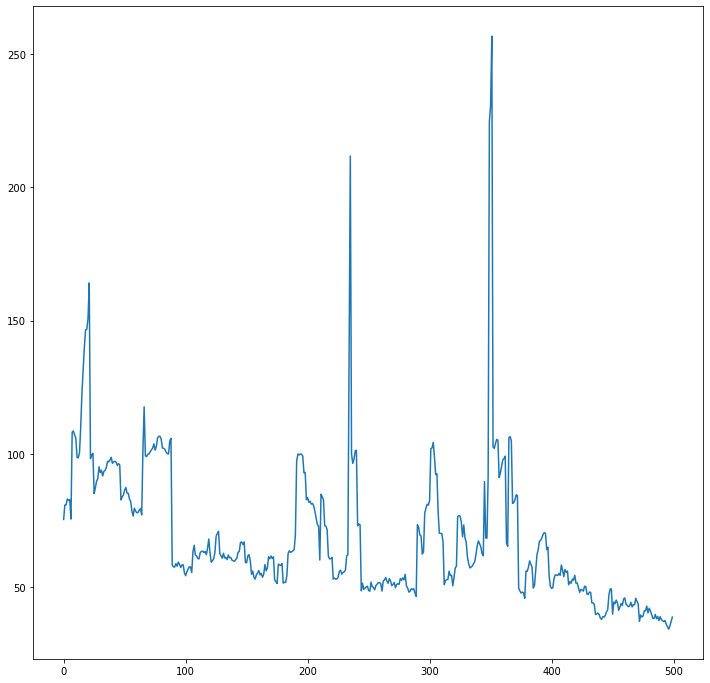

In [70]:
plt.plot(mre_loss[:500])

In [62]:
np.mean(mre_loss)

381.57126725845336

In [64]:
with open('mre_loss_1.pkl','wb') as f:
    pickle.dump(mre_loss,f)

In [39]:
loss

BCELoss()

In [27]:
dif = []
g3 = generator(noise(100000))
for item in g3:
    dif.append(np.sum(np.abs(item.cpu().detach().numpy().reshape(19,7)-tensor_array[1])))

In [44]:
dif = []
for item in g3:
    dif.append(np.sum(np.abs(item.cpu().detach().numpy().reshape(19,7)-tensor_array[10000])))
print(np.min(dif))

36.4557402940318


In [45]:
np.min(dif) / 133

0.2741033104814421

In [33]:
np.max(dif)

6552.870897216797

In [38]:
np.min(dif)

62.10247220611572

In [ ]:
# RMSE
np.sqrt(np.sum(np.power(loss,2)) / 133)

In [ ]:
np.sum(np.abs(loss)) 

In [ ]:
# MSE
np.sum(np.power(loss,2)) / 133

In [ ]:
loss

In [ ]:
mre

In [ ]:
g2 = generator(noise(1))

In [ ]:
np.sum(np.abs(loss))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
std_list

In [ ]:
plt.hist(mean_list,bins=100)

In [ ]:
plt.hist(std_list,bins=100)

## load tensor_array2 

In [41]:
cd ..

/home/esmidth/github/CCS_TA_implement


In [42]:
import pickle
with open('tensor2.pkl','rb') as f:
    tensor_array = pickle.load(f)

In [43]:
mean_list = []
std_list = []
for item in tensor_array:
    mean_list.append(np.mean(item))
    std_list.append(np.std(item))